In [1]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
%matplotlib inline

In [16]:
#gdf = aup.gdf_from_db("mpos_2020", "marco")
mpos = ['01001','01005','01011']
mun_gdf = gpd.GeoDataFrame()
hex_bins = gpd.GeoDataFrame()
for m in mpos:
    query = f"SELECT * FROM processed.hex_bins_dist_2020 WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_bins = hex_bins.append(aup.gdf_from_query(query, geometry_col='geometry'))
    query = f"SELECT * FROM marco.mpos_2020 WHERE \"CVEGEO\" LIKE \'{m}\'"
    mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))

In [17]:
print(hex_bins.shape)
hex_bins.head(2)

(2088, 6)


,geometry,hex_id_8,CVEGEO,dist_farmacia,dist_hospitales,dist_supermercados
0,"POLYGON ((-102.31835 21.82096, -102.31376 21.8...",88498eacd7fffff,01001,3709.637939,4909.378082,1570.290122
1,"POLYGON ((-102.25877 21.81044, -102.26386 21.8...",88498eac33fffff,01001,1808.395005,5629.700215,2665.346815


<AxesSubplot:>

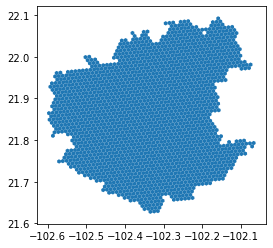

In [18]:
hex_bins.plot()

In [19]:
print(mun_gdf.shape)
mun_gdf.head(2)

(3, 5)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,01001,01,001,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0..."
0,01005,01,005,Jesús María,"POLYGON ((-102.33568 22.05067, -102.33348 22.0..."


<AxesSubplot:>

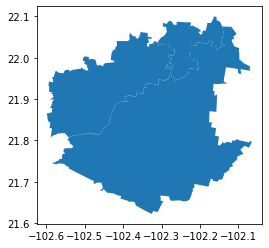

In [20]:
mun_gdf.plot()

In [21]:
gdf_tmp = mun_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [22]:
query = f"SELECT * FROM processed.nodes_dist_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
nodes = aup.gdf_from_query(query, geometry_col='geometry')
print(nodes.shape)
nodes.head(2)

(49955, 7)


,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),334.213,716.149,232.373
1,272921393,-102.295097,21.871411,POINT (-102.29510 21.87141),183.576,553.205,71.637


<AxesSubplot:>

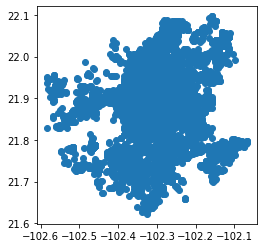

In [23]:
nodes.plot()

In [32]:
nodes_filter = nodes.loc[(nodes['dist_supermercados'] > 0) &
                        (nodes['dist_farmacia'] > 0) &
                        (nodes['dist_hospitales'] > 0)].copy()
print(nodes_filter.shape)
nodes_filter.head(2)

(49086, 7)


,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),334.213,716.149,232.373
1,272921393,-102.295097,21.871411,POINT (-102.29510 21.87141),183.576,553.205,71.637


In [33]:
#removes big distance values to avoid errors
nodes_filter['dist_supermercados'] = nodes_filter['dist_supermercados'].apply(lambda x: x if x <= 10000 else 10000)
nodes_filter['dist_farmacia'] = nodes_filter['dist_farmacia'].apply(lambda x: x if x <= 10000 else 10000)

#calculate index
#hospital index
nodes_filter['ind_hospitales'] =  nodes_filter.apply (lambda row: 1 / (1 + math.exp( 0.00109861 * (row.loc['dist_hospitales'] - 3000 ))), axis=1)
nodes_filter['ind_supermercado'] = nodes_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_supermercados'] - 650 ))), axis=1)
nodes_filter['ind_farmacias'] = nodes_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_farmacia'] - 650 ))), axis=1)
nodes_filter['ind_accesibilidad'] = nodes_filter.apply (lambda row: (0.333*row.loc['ind_supermercado']) + (0.334*row.loc['ind_farmacias']) + (0.333*row.loc['ind_hospitales']), axis=1)

In [34]:
nodes_filter.head(2)

,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados,ind_hospitales,ind_supermercado,ind_farmacias,ind_accesibilidad
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),334.213,716.149,232.373,0.924775,0.93225,0.878941,0.911955
1,272921393,-102.295097,21.871411,POINT (-102.29510 21.87141),183.576,553.205,71.637,0.936319,0.97419,0.949219,0.953238


<AxesSubplot:>

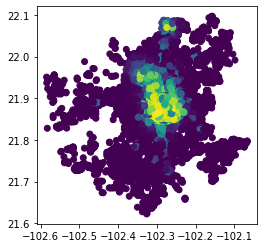

In [36]:
nodes_filter.plot(nodes_filter.ind_accesibilidad)

In [50]:
hex_filter = hex_bins.loc[(hex_bins['dist_supermercados'] > 0) &
                        (hex_bins['dist_farmacia'] > 0) &
                        (hex_bins['dist_hospitales'] > 0)].copy()
print(hex_filter.shape)
hex_filter.head(2)

(1295, 6)


,geometry,hex_id_8,CVEGEO,dist_farmacia,dist_hospitales,dist_supermercados
0,"POLYGON ((-102.31835 21.82096, -102.31376 21.8...",88498eacd7fffff,01001,3709.637939,4909.378082,1570.290122
1,"POLYGON ((-102.25877 21.81044, -102.26386 21.8...",88498eac33fffff,01001,1808.395005,5629.700215,2665.346815


In [51]:
#removes big distance values to avoid errors
hex_filter['dist_supermercados'] = hex_filter['dist_supermercados'].apply(lambda x: x if x <= 10000 else 10000)
hex_filter['dist_farmacia'] = hex_filter['dist_farmacia'].apply(lambda x: x if x <= 10000 else 10000)

#calculate index
#hospital index
hex_filter['ind_hospitales'] =  hex_filter.apply (lambda row: 1 / (1 + math.exp( 0.00109861 * (row.loc['dist_hospitales'] - 3000 ))), axis=1)
hex_filter['ind_supermercado'] = hex_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_supermercados'] - 650 ))), axis=1)
hex_filter['ind_farmacias'] = hex_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_farmacia'] - 650 ))), axis=1)
hex_filter['ind_accesibilidad'] = hex_filter.apply (lambda row: (0.333*row.loc['ind_supermercado']) + (0.334*row.loc['ind_farmacias']) + (0.333*row.loc['ind_hospitales']), axis=1)

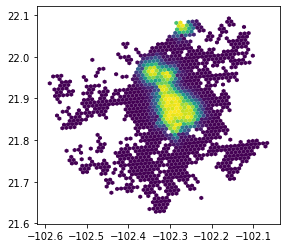

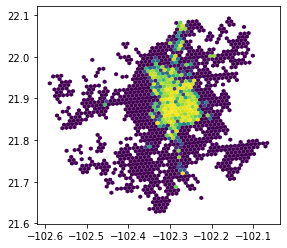

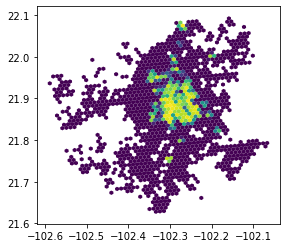

In [52]:
ind = ['ind_hospitales','ind_supermercado','ind_farmacias']
for i in ind:
    hex_filter.plot(hex_filter[i])

In [54]:
hex_filter.ind_accesibilidad.mean()

0.11643512198920729

In [55]:
nodes_filter.ind_accesibilidad.mean()

0.4425886174343631

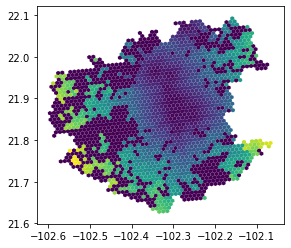

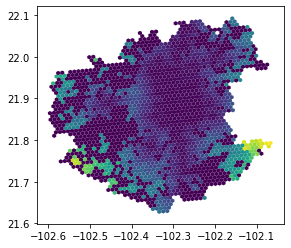

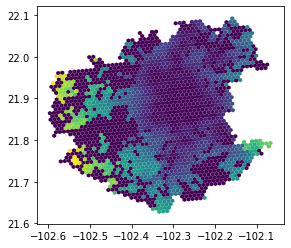

In [44]:
ind = ['dist_hospitales','dist_supermercados','dist_farmacia']
for i in ind:
    hex_bins.plot(hex_bins[i])